In [1]:
# Make code toggle-able for easier review.
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<i>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a></i>.''')

In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 50

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from sklearn.preprocessing import Imputer

from scipy.stats import normaltest
from itertools import cycle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import linear_model


In [3]:
# Read the data
filepath = '/Users/guest/Dropbox/Education/Thinkful/Unit 3 - Deeper into supervised learning/Lesson 3 - Advanced Regression/U3L3P4 - Regression Challenge/database.csv'

collisions = pd.read_csv(filepath)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (9,12,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Set color library & define a dictionary to store color definitions
cycol = cycle('bgrcmk')
color_defs = {}

In [5]:


# Define a function that splits a list into n-length chunks
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

# Define a histogram plotting function that utilizes the chunk function to yield n-length rows of histograms
def plot_hists(frame, vs, width, colors=list(sns.color_palette("Set3").as_hex())):
    variables_chunked = chunks(vs, width) # Chunk the list of variables
    
    my_colors = colors
    
    # Create a chart for each chunk
    for chunk in variables_chunked:
        fig, axes = plt.subplots(1, len(chunk), figsize=(10,2))
        fig.tight_layout()
        
        # Plot the variables in each chunk's charts
        for var in chunk:
            idx = chunk.index(var)
            color_defs[var] = next(cycol)
            frame.hist(var, ax=axes[idx], xrot=90, 
                       color=color_defs[var], alpha=0.5)
            
        
        plt.show()
        
# Define a bar chart plotting function that utilizes the chunk function to yield n-length rows of bar charts
def plot_bars(frame, vs, width):
    variables_chunked = chunks(vs, width) # Chunk the list of variables
    
    # Create a chart for each chunk
    for chunk in variables_chunked:
        fig, axes = plt.subplots(1, len(chunk), figsize=(10,2))
        fig.tight_layout()
        if len(chunk) > 1:
            # Plot the variables in each chunk's charts
            for var in chunk:
                idx = chunk.index(var)
                color_defs[var] = cycol
                frame[var].value_counts().head(20).plot.bar(ax=axes[idx], title=var, color=color_defs[var], alpha=0.5)
        else:
            color_defs[chunk[0]] = next(cycol)
            frame[chunk[0]].value_counts().head(20).plot.bar(title=chunk[0], color=color_defs[var], alpha=0.5)
            
        plt.show()

        
######
###### Function for visualizing and quantifying the impact of mathematical transformations on features
######

def transformation_test(data, 
                        variable, 
                        alpha=0.05, 
                        colors=(['blue']*7),
                        output_all=True):    
    
    # Define transformation functions when necessary and store them in a dictionary.
    def untransformed(x):return x
    def square(x):return x**2
    def cube(x):return x**3
    def recip(x): return 1/x

    tests = {'no_transformation':untransformed,
             'squared_data':square,
             'cubed_data':cube,
             'square_root':np.sqrt,
             'cube_root':np.cbrt,
             'log':np.log,
             'reciprocal':recip}
    
    # Transform the variables & store outputs
    test_df = pd.DataFrame(columns=list(tests)) # Create a dataframe to store the transformed variables in
    
    # Create a dictionary to store test outputs
    output_dict = {'transformation':list(tests.keys()),
                   'test_statistic':[],
                   'p_value':[]
                  }
        
    for element in tests: # Iterate through the dictionary of transformation functions
        
        # Apply transformation to target variable & store it in the dataframe
        test_df[element] = data[variable].apply(lambda x: tests[element](x)) 
        
        # Perform the statistical test & generate a summary readout
        stat, p = normaltest(test_df[element])
        output_dict['test_statistic'].append(round(stat,2))
        output_dict['p_value'].append(round(p,4))
        
    def p_check(p, alpha):
        if p < alpha:
            return 0
        else:
            return 1
        
    output_df = pd.DataFrame(output_dict, columns = ['transformation', 'test_statistic', 'p_value'])
    output_df['normal'] = np.where(output_df['p_value']> alpha, True, False)
            
    
    # Plot histograms of the transformations
    plot_hists(test_df,
               list(tests),
               width=7,
               colors=(colors))
    plt.show
    
    # Print statistical readouts
    if output_all == False:
        if output_df.loc[output_df['normal'] == True].shape[0] > 0:
            print('Returning transformations that made the data normal.\n')
            return output_df.loc[output_df['normal'] == True]
        else:
            nearest_match = output_df.loc[output_df['test_statistic'] == output_df['test_statistic'].min()]
            
            print('None of the applied transformations made the distribution normal! Returning nearest match.\n')
            return nearest_match
            
    else:
        return output_df



## _Outcome Variable_

###### I'm interested in the binary outcome of __whether or not the collision had an impact on the flight__. My outcome variable will be the 'Flight Outcome' variable, recoded such that __1__ indicates some form of impact (_'PRECAUTIONARY LANDING', 'OTHER', 'ABORTED TAKEOFF', 'NONE'_, or _'ENGINE SHUTDOWN'_) on the flight & __0__ indicates no impact (_'NONE'_).

I'm going to drop all observations where flight outcome is NaN. Unfortunately, NaN flight outcomes constitute a pretty big chunk of the data. 

In [6]:
total_count = collisions.shape[0]
null_values = collisions['Flight Impact'].isnull().sum()
not_null = collisions['Flight Impact'].shape[0] - null_values
print('Of {} total observations, Flight Impact is coded as nan {} times & as something other than nan {} times.'.format(total_count, null_values, not_null))

Of 174104 total observations, Flight Impact is coded as nan 74639 times & as something other than nan 99465 times.


###### While I'd be willing to bet that NaNs disproportionately represent _'NONE'_, I don't have any way to support that assumption. The set is large enough that I don't think the loss of data should matter too much to my model.

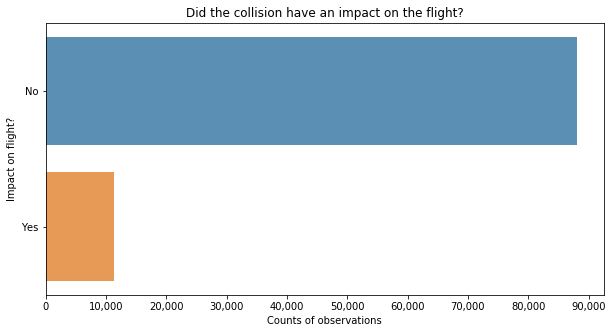

In [7]:
# Copy the raw dataframe, dropping observations where Flight Impact == 0
collisions_2 = collisions.copy().dropna(subset=['Flight Impact'])

# Create a dataframe to store features in
model_vars = pd.DataFrame({'flight_outcome':pd.get_dummies(collisions_2['Flight Impact'])['NONE']})
model_vars['flight_outcome'] = model_vars['flight_outcome'].apply(lambda x: np.logical_not(x).astype(int))
collisions_2['flight_outcome_recoded'] = model_vars['flight_outcome']

# Visualize the outcome variable
plt.figure(figsize=(10,5))

ax = sns.countplot(y=model_vars['flight_outcome'], alpha=0.8)

ax.set_title('Did the collision have an impact on the flight?')
ax.set_ylabel('Impact on flight?')
ax.set_xlabel('Counts of observations')

ax.set_xticks(np.arange(0,100000,10000))
ax.set_yticklabels(['No', 'Yes'])
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.show()

## Feature Selection - Round 1

In [8]:
# Define lists of all the categorical variables and all the numeric variables for later use.
categorical_variables = list(collisions.describe(include=[np.object]))
numeric_variables = list(collisions.describe(include=[np.number]))

### Numeric Variables

###### Dealing with nulls

In [9]:
for col in collisions_2[list(collisions_2.describe(include=[np.number]))]:
    if collisions_2[col].isnull().sum() > 0:
        print('{}: {}'.format(col, collisions_2[col].isnull().sum()))

Aircraft Mass: 2753
Engine Make: 4794
Engines: 2840
Engine2 Position: 9971
Engine4 Position: 97568
Height: 14499
Speed: 37179
Distance: 50136
Fatalities: 98913
Injuries: 99258


Aircraft Mass, Engine Make, Engines, Engine2 Position, and Engine4 Position, all have high numbers of missing values, but they're also all categorical. I'm going to get dummies for them.

In [10]:
collisions_2 = pd.get_dummies(data=collisions_2, columns=['Aircraft Mass','Engine Make', 'Engines', 'Engine2 Position', 'Engine4 Position'])

NaNs in 'Injuries' and 'Fatalities' almost certainly reflect 0s. I'm going to replace them.

In [11]:
collisions_2[['Injuries', 'Fatalities']] = collisions_2[['Injuries', 'Fatalities']].fillna(value=0)

I'm going to attempt to impute for Height, Speed, and Distance. 

In [12]:
values = collisions_2[list(collisions_2.describe(include=[np.number]))]
imputer = Imputer()
transformed_values = imputer.fit_transform(values)

collisions_w_imputation = pd.DataFrame(transformed_values, columns=list(collisions_2.describe(include=[np.number])))

collisions_2[['Height', 'Speed', 'Distance']] = collisions_w_imputation[['Height', 'Speed', 'Distance']].values

In [13]:
for col in collisions_2[list(collisions_2.describe(include=[np.number]))]:
    if collisions_2[col].isnull().sum() > 0:
        print('{}: {}'.format(col, collisions_2[col].isnull().sum()))

Great! I've accounted for all of the nulls for all of the numeric variables.

###### DATE: 'Incident Year,' 'Incident Month,' and 'Incident Day' appear to contain some pretty interesting patterns (which, incidentally, would probably be worth some deeper analysis unto themselves – what's with that uptick of collisions on the 30th? Why are these collisions increasing over time? Why do they peak in fall?), so I'll definitely be including them in my features. They'd likely be a bit more honest if I could weigh them by the overall number of flights in the same time periods, but I don't have that data on-hand.

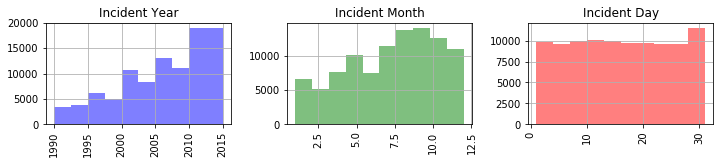

In [14]:
plot_hists(collisions_2, ['Incident Year', 'Incident Month', 'Incident Day'], 3)

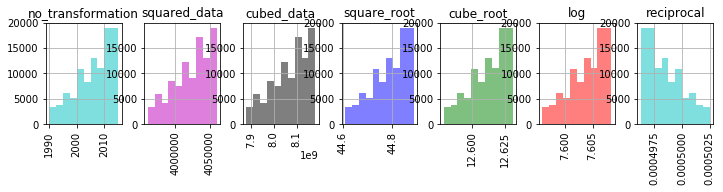

      transformation  test_statistic  p_value  normal
0  no_transformation         9417.14      0.0   False
1       squared_data         9516.76      0.0   False
2         cubed_data         9620.84      0.0   False
3        square_root         9368.97      0.0   False
4          cube_root         9353.16      0.0   False
5                log         9321.91      0.0   False
6         reciprocal         9231.01      0.0   False


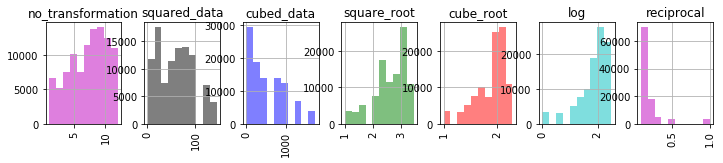

      transformation  test_statistic  p_value  normal
0  no_transformation         7124.57      0.0   False
1       squared_data        10544.88      0.0   False
2         cubed_data         8864.02      0.0   False
3        square_root         9993.51      0.0   False
4          cube_root        15108.30      0.0   False
5                log        28900.04      0.0   False
6         reciprocal        71208.69      0.0   False


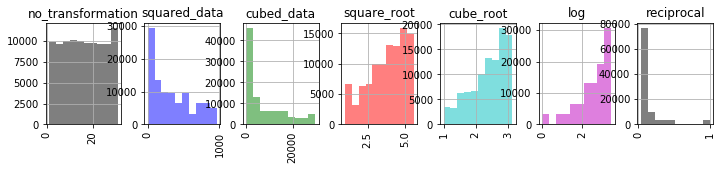

      transformation  test_statistic  p_value  normal
0  no_transformation        82950.08      0.0   False
1       squared_data        16321.04      0.0   False
2         cubed_data        12844.06      0.0   False
3        square_root        10681.38      0.0   False
4          cube_root         7694.82      0.0   False
5                log        18261.71      0.0   False
6         reciprocal        69680.59      0.0   False


In [15]:
for variable in ['Incident Year', 'Incident Month', 'Incident Day']:
    print(transformation_test(data=collisions_2,
                              variable=variable,
                              alpha=0.05,
                              colors=([color_defs['Incident Year']] + (['grey'] * 6))))

None of these shake out a – I'm going to incorporate each year as its own binary variable, each month into its own binary variable, and leave out day of incident for now.

In [16]:
model_vars[['Incident Year', 'Incident Month']] = collisions_2[['Incident Year', 'Incident Month']]
model_vars = pd.get_dummies(data=model_vars, columns=['Incident Year', 'Incident Month'])

###### _'Height'_ and _'Distance'_ are notable because of how overwhelmingly they gravitate towards zero. Most collisions seem to happen before the planes leave the ground! I'm going to incorporate them as binary features. _'Speed'_ has a pretty healthy looking two-tailed distribution that squares well with the observation that collisions happen before & during takeoff. It looks like I'll be able to incorporate it as a continuous variable.

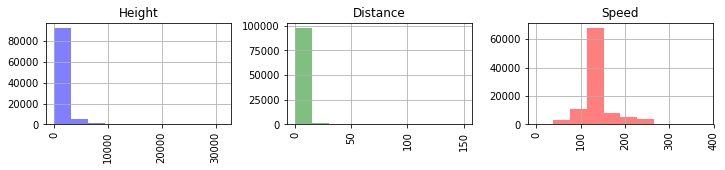

In [17]:
plot_hists(collisions_2, ['Height', 'Distance', 'Speed'], 3)

In [18]:
# Incorporate height & distance binary variables where values of less than 1 are 0 and all others are 1.
model_vars['height_bin'] = np.where(collisions_2['Height'] < 1, 0, 1)
model_vars['distance_bin'] = np.where(collisions_2['Distance'] < 1, 0, 1)

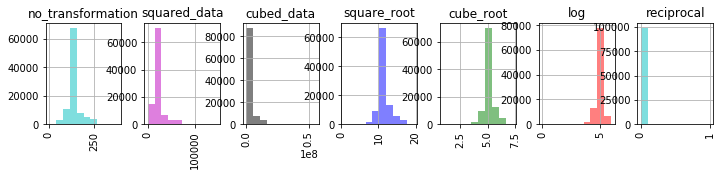

      transformation  test_statistic  p_value  normal
0  no_transformation        15987.61      0.0   False
1       squared_data        49412.80      0.0   False
2         cubed_data        75550.05      0.0   False
3        square_root        14618.58      0.0   False
4          cube_root        31662.10      0.0   False
5                log        98646.90      0.0   False
6         reciprocal       270493.86      0.0   False


In [19]:
# Add a constant to the speed variable so it can be logged and inverted
collisions_2['Speed_plus1'] = collisions_2['Speed'] + 1

# Test transformations on speed
print(transformation_test(data=collisions_2,
                          variable='Speed_plus1',
                          alpha=0.05,
                          colors=([color_defs['Speed']] + (['grey'] * 6))))

None of these transformations made my data normal! I'm going to proceed with the square root, because it looks best. However, the mode is extremely frequent.

In [20]:
model_vars['speed_sqrt'] = np.sqrt(collisions_2['Speed'])

###### _'Injuries'_ and _'Fatalities'_ are so rare that they're barely correlated with flight outcome. They're not going to be useful as features.

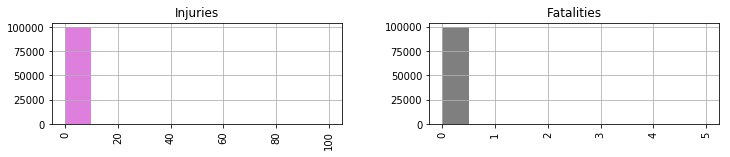

17.0 fatalities and 376.0 injuries across 99465 observations.

Variable/Outcome Correlation Coefficients:
Injuries      0.03
Fatalities    0.02
Name: flight_outcome_recoded, dtype: float64


In [21]:
plot_hists(collisions_2, ['Injuries', 'Fatalities'], 2)

print('{} fatalities and {} injuries across {} observations.'.format(collisions_2['Fatalities'].sum(), collisions_2['Injuries'].sum(), collisions_2.shape[0]))

print('\nVariable/Outcome Correlation Coefficients:')
print(round(collisions_2[['Injuries', 'Fatalities', 'flight_outcome_recoded']].corr()['flight_outcome_recoded'][:2],2))

###### Points of impact and damage I'm interested in all the variables that specify the impact location (_'Aircraft Damage', 'Radome Strike', 'Radome Damage', 'Windshield Strike', 'Windshield Damage', 'Nose Strike', 'Nose Damage', 'Engine1 Strike', 'Engine1 Damage', 'Engine2 Strike', 'Engine2 Damage', 'Engine3 Strike', 'Engine3 Damage', 'Engine4 Strike', 'Engine4 Damage', 'Engine Ingested', 'Propeller Strike', 'Propeller Damage', 'Wing or Rotor Strike', 'Wing or Rotor Damage', 'Fuselage Strike', 'Fuselage Damage', 'Landing Gear Strike', 'Landing Gear Damage', 'Tail Strike', 'Tail Damage', 'Lights Strike', 'Lights Damage', 'Other Strike', _&_ 'Other Damage'_) – what points of impact, if any, are most likely to impact flight outcome?

In [22]:
impact_location_variables = ['Aircraft Damage', 'Radome Strike', 
                             'Radome Damage', 'Windshield Strike', 
                             'Windshield Damage', 'Nose Strike', 
                             'Nose Damage', 'Engine1 Strike', 
                             'Engine1 Damage', 'Engine2 Strike', 
                             'Engine2 Damage', 'Engine3 Strike', 
                             'Engine3 Damage', 'Engine4 Strike', 
                             'Engine4 Damage', 'Engine Ingested', 
                             'Propeller Strike', 'Propeller Damage', 
                             'Wing or Rotor Strike', 'Wing or Rotor Damage', 
                             'Fuselage Strike', 'Fuselage Damage', 
                             'Landing Gear Strike', 'Landing Gear Damage', 
                             'Tail Strike', 'Tail Damage', 
                             'Lights Strike', 'Lights Damage', 
                             'Other Strike', 'Other Damage']

impact_location_summaries = {'variable':[], 'count':[], 'percent':[], 'corr':[], 'nans':[]}

for var in impact_location_variables:
    impact_location_summaries['variable'].append(var)
    impact_location_summaries['count'].append(collisions_2[var].sum())
    impact_location_summaries['percent'].append(round(collisions_2[var].sum()/collisions_2.shape[0],2))
    impact_location_summaries['nans'].append(collisions_2[var].isnull().sum())
    impact_location_summaries['corr'].append(round(collisions_2[[var, 'flight_outcome_recoded']].corr()['flight_outcome_recoded'][:1].sum(),2))

# Return variables with a correlation coefficient with the outcome variable of greater than 0.2.
impact_location_df = pd.DataFrame(impact_location_summaries, columns=list(impact_location_summaries.keys()))
print(impact_location_df[abs(impact_location_df['corr']) >0.2])


           variable  count  percent  corr  nans
0   Aircraft Damage  11380     0.11  0.35     0
8    Engine1 Damage   1875     0.02  0.22     0
15  Engine Ingested   6578     0.07  0.25     0


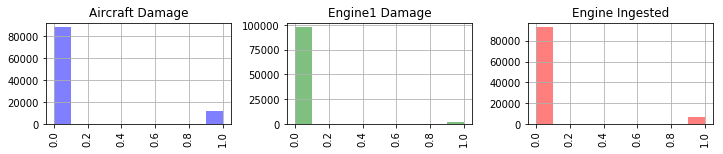

In [23]:
plot_hists(collisions_2, ['Aircraft Damage', 'Engine1 Damage', 'Engine Ingested'], 3)

It looks like strikes that impact engines and the windshield are the most likely to impact flight outcome. Makes sense! I'll go ahead and incorporate them into my features.

In [24]:
model_vars[['Aircraft Damage', 'Engine1 Damage', 'Engine Ingested']] = collisions_2[['Aircraft Damage', 'Engine1 Damage', 'Engine Ingested']]

### Categorical Variables

###### I'm interested in whether the species that collides with an airplane has an effect on whether or not the collision has an impact on the flight. However, over 750 species are named in the data & most of them don't occur very often. I'm going to rule out all unknown species, set the cutoff for inclusion at 1000, and build binary features for the remaining species.

In [25]:
# Get counts for each species
common_species = collisions_2.groupby(['Species Name'], as_index=False).count().sort_values(by='Record ID', ascending=False)[['Species Name', 'Record ID']]

# Filter out unknown species & species with few incidents
common_species = common_species[(common_species['Species Name'].str.contains("UNKNOWN") == False) & (common_species['Record ID'] > 1000)]

# Create new binary columns for the most common species
for species in list(common_species['Species Name']):
    model_vars[species] = np.where(collisions_2['Species Name'] == species, 1, 0)

### Checking Correlations

In [26]:
# Return variables with a correlation coefficient with the outcome variable of greater than 0.2.
corrs_with_outcome = {'variables':[], 'correlation':[]}

for variable in list(model_vars.drop('flight_outcome', axis=1)):
    corrs_with_outcome['variables'].append(variable)
    corrs_with_outcome['correlation'].append(model_vars[['flight_outcome', variable]].corr()[variable].sum() - 1)

outcome_corrs_df = pd.DataFrame(corrs_with_outcome)
#print(impact_location_df[abs(impact_location_df['corr']) > 0.2])

In [27]:
outcome_corrs_df[outcome_corrs_df['correlation'] > 0.2]

,correlation,variables
41,0.353963,Aircraft Damage
42,0.219079,Engine1 Damage
43,0.250244,Engine Ingested


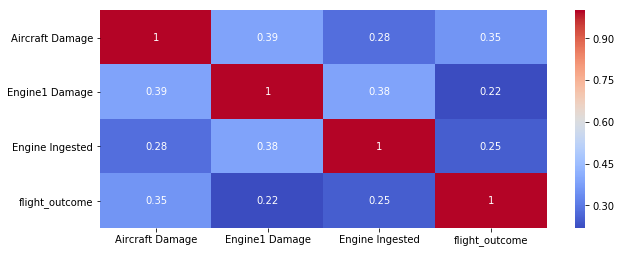

In [28]:
plt.figure(figsize=(10,4))
sns.heatmap(model_vars[['Aircraft Damage', 'Engine1 Damage', 'Engine Ingested', 'flight_outcome']].corr(), cmap="coolwarm", annot=True)
plt.show()

###### That's unpleasant! A lot of my guesses about what would be useful were flatly wrong, and my remaining features aren't particularly attractive  – they're all binary, and many are more correlated with each other than with my target outcome. I'm going to try to brute force my way to a few more features by checking all features' correlations with my outcome.

In [29]:
# Return variables with a correlation coefficient with the outcome variable of greater than 0.2.
corrs_with_outcome = {'variables':[], 'correlation':[]}

test = pd.get_dummies(collisions_2)

for variable in list(test.drop('flight_outcome_recoded', axis=1)):
    corrs_with_outcome['variables'].append(variable)
    corrs_with_outcome['correlation'].append(abs(test[['flight_outcome_recoded', variable]].corr()[variable].sum() - 1))

outcome_corrs_df = pd.DataFrame(corrs_with_outcome)
outcome_corrs_df[(abs(outcome_corrs_df['correlation']) > 0.2) & (outcome_corrs_df['variables'].str.contains("Flight Impact") == False)]

,correlation,variables
9,0.353963,Aircraft Damage
17,0.219079,Engine1 Damage
24,0.250244,Engine Ingested
42,0.217533,Aircraft Mass_4.0
75,0.216811,Engines_1.0
1964,0.252595,Engine Type_D


###### Ok, so 'Aircraft Mass 4.0,' 'Engines 1.0,' and 'Engine Type_D' are all reasonably correlated with the outcome. How do they look in a correlation matrix with everything else?

In [30]:
model_vars[['ac_mass_4', 'engines_1']] = collisions_2[['Aircraft Mass_4.0', 'Engines_1.0']]
model_vars['engine_type_d'] = pd.get_dummies(collisions_2['Engine Type'])['D']

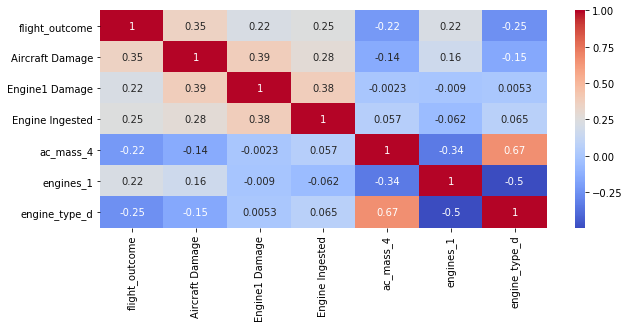

In [31]:
plt.figure(figsize=(10,4))
sns.heatmap(model_vars[['flight_outcome','Aircraft Damage', 'Engine1 Damage', 'Engine Ingested', 'ac_mass_4', 'engines_1', 'engine_type_d']].corr(), cmap="coolwarm", annot=True)
plt.show()

###### What I'm seeing here is that I still have a bunch of very cruddy features. There's more information in this heatmap about how different airplanes are configured than there is about my outcome variable. 

###### I'm willing to blame the data for this - there seems to be a lot of noise overall, there were a lot of NaNs to begin with, and some variables, like species, aren't as specific as they ought to be. Maybe pilots are lazy about their paperwork. At any rate, I'm going to proceed the best that I can with what I've got. 
<br>

__The Gameplan:<br>__
_1) I'm going to set the correlation-with-outcome cutoff at 0.1 – even lower than it already is. <br>
2) I'll run PCA on that data so that my vanilla regression has something to eat.<br>
3) I'll see how ridge and LASSO fare with the un-PCRed data._

## Feature Selection - Round 2

In [32]:
# Clean up column names
model_vars.columns = model_vars.columns.str.replace(' ','_')
model_vars.columns = map(str.lower, model_vars.columns)

In [33]:
# Create a new dataframe containing only those variables which have a correlation coefficient of more than 0.1 with 
# the outcome variable.

# Get a list of correlated variables
vars_correlated_with_outcome = outcome_corrs_df[(abs(outcome_corrs_df['correlation']) > 0.1) & 
                                                (outcome_corrs_df['variables'].str.contains("Flight Impact") == False)]
vars_cwo_list = list(vars_correlated_with_outcome['variables'])

# Create the dataframe
collisions_3 = pd.get_dummies(collisions_2)[vars_cwo_list]
collisions_3['flight_outcome'] = collisions_2['flight_outcome_recoded']

In [34]:
# Drop NA values; our dataset is big enough to tolerate it anyway.
collisions_3 = collisions_3.dropna(axis=1)

###### Define X & Y

In [35]:
X = collisions_3
Y = collisions_3['flight_outcome']

## Regression Models

### Vanilla Regression

###### Run PCA

In [36]:
X_PCA = X.select_dtypes(include=[np.float, np.number])

sklearn_pca = PCA(n_components=1)
Y_sklearn = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

total_explained_variance = 0
for percentage in list(sklearn_pca.explained_variance_ratio_):
    total_explained_variance += percentage
    
total_explained_variance = round(total_explained_variance * 100,2)

print('Components explain {}% of total variance.'.format(total_explained_variance))

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.99999966]
Components explain 100.0% of total variance.


In [37]:
X_PCA = pd.DataFrame(Y_sklearn, columns=['comp_1'])

In [38]:
X_PCA_train, X_PCA_test, y_PCA_train, y_PCA_test = train_test_split(X_PCA,Y)

In [39]:
# Instantiate the model
ols_regr = linear_model.LinearRegression()
ols_regr.fit(X_PCA_train, y_PCA_train)

# Inspect the results.
print('\nCoefficients: \n', ols_regr.coef_)
print('\nIntercept: \n', ols_regr.intercept_)
print('\nR-squared:')
print(ols_regr.score(X_PCA_test, y_PCA_test))


Coefficients: 
 [5.22327089e-07]

Intercept: 
 0.11392381868817085

R-squared:
0.021808528438407637


###### What a stinker. I wonder how the other models will fare.

### Ridge Regression

In [40]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,Y)

In [41]:
ridge = linear_model.Ridge(alpha=10)
ridge.fit(X_train, y_train)

# Inspect the results.
print('\nCoefficients: \n', ridge.coef_)
print('\nIntercept: \n', ridge.intercept_)
print('\nR-squared:')
print(ridge.score(X_test, y_test))


Coefficients: 
 [ 8.18964376e-11 -2.94790035e-06 -2.94898604e-07  2.68390002e-04
  4.77792923e-04  7.14590361e-05  2.73094146e-04  4.81190274e-05
  2.98686971e-04  3.10851121e-04  4.29673460e-05  1.94989589e-04
 -2.88903780e-05  1.14985005e-04  2.06261127e-04  2.56475832e-04
  8.47307894e-05  2.98306575e-05 -4.88716522e-05  6.73094096e-05
  1.30445642e-04  7.46750586e-06  6.02068207e-07 -2.94898864e-07
  1.23623067e-05  2.75137724e-04  8.78220735e-06  1.23623067e-05
  2.75137724e-04  8.78220735e-06 -2.00060279e-05  2.73314237e-04
  4.16205447e-05 -5.47373776e-05 -6.41704839e-05  3.81260599e-05
 -6.80443500e-06  7.11379738e-05 -1.96858385e-06  2.45101175e-04
  1.78746763e-04 -6.26252740e-05  2.60930609e-04  2.30310203e-04
 -3.99611222e-05 -3.99611222e-05  2.30310203e-04 -5.82421798e-05
  9.98096064e-01]

Intercept: 
 0.006159530750543596

R-squared:
0.9999974426792034


### LASSO Regression

In [42]:
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Inspect the results.
print('\nCoefficients: \n', ridge.coef_)
print('\nIntercept: \n', ridge.intercept_)
print('\nR-squared:')
print(lasso.score(X_test, y_test))


Coefficients: 
 [ 8.18964376e-11 -2.94790035e-06 -2.94898604e-07  2.68390002e-04
  4.77792923e-04  7.14590361e-05  2.73094146e-04  4.81190274e-05
  2.98686971e-04  3.10851121e-04  4.29673460e-05  1.94989589e-04
 -2.88903780e-05  1.14985005e-04  2.06261127e-04  2.56475832e-04
  8.47307894e-05  2.98306575e-05 -4.88716522e-05  6.73094096e-05
  1.30445642e-04  7.46750586e-06  6.02068207e-07 -2.94898864e-07
  1.23623067e-05  2.75137724e-04  8.78220735e-06  1.23623067e-05
  2.75137724e-04  8.78220735e-06 -2.00060279e-05  2.73314237e-04
  4.16205447e-05 -5.47373776e-05 -6.41704839e-05  3.81260599e-05
 -6.80443500e-06  7.11379738e-05 -1.96858385e-06  2.45101175e-04
  1.78746763e-04 -6.26252740e-05  2.60930609e-04  2.30310203e-04
 -3.99611222e-05 -3.99611222e-05  2.30310203e-04 -5.82421798e-05
  9.98096064e-01]

Intercept: 
 0.006159530750543596

R-squared:
0.032508388473983296
